In [1]:
!date

In [2]:
pwd

'/mmfs1/data/aglinska/BC-fMRI-AE/Notebooks'

In [3]:
%%time

import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
from tqdm import tqdm
from helper_funcs import *
import shutil
from scipy.stats import ttest_ind,ttest_1samp,ttest_rel

import umap

CPU times: user 9.63 s, sys: 4.77 s, total: 14.4 s
Wall time: 27.2 s


In [4]:
analysis_name = 'CVAE_2022-03-25 18:28:49.469238'
save_dir = os.path.join('../Assets/tf_weights',analysis_name)

In [5]:
def dummy_ordinal(invec):
    unique_values = np.unique(invec)
    new_values = np.arange(1,len(unique_values)+1)
    new_arr = [new_values[val==unique_values][0] for val in invec]
    return new_arr

In [6]:
def flatten_cmat(cmats):
    ns = cmats.shape[0]
    ni = cmats.shape[-1]
    tridx = np.triu_indices(n=ni,k=1)
    mat_flat = np.array([cmats[i,:,:][tridx] for i in range(ns)])
    return mat_flat

In [7]:
rnames = ['LH-Vis-EVC','LH-SomMot-Mot','LH-DorsAttn-Post','LH-DorsAttn-FEF','LH-DorsAttn-PrCv','LH-SalVentAttn-ParOper','LH-SalVentAttn-TempOcc','LH-SalVentAttn-FrOper','LH-SalVentAttn-PFCl','LH-SalVentAttn-Med','LH-Limbic-OFC','LH-Limbic-TempPole','LH-Cont-Par','LH-Cont-Temp','LH-Cont-PFCd','LH-Cont-PFCl','LH-Cont-OFC','LH-Cont-PFCv','LH-Cont-pCun','LH-Cont-Cing','LH-Cont-PFCmp','LH-Default-Par','LH-Default-Temp','LH-Default-PFC','LH-Default-PCC','LH-Default-PHC','RH-Vis-EVC','RH-SomMot-Mot','RH-DorsAttn-Post','RH-DorsAttn-FEF','RH-DorsAttn-PrCv','RH-SalVentAttn-TempOccPar','RH-SalVentAttn-PrC','RH-SalVentAttn-FrOper','RH-SalVentAttn-PFCv','RH-SalVentAttn-PFCl','RH-SalVentAttn-Med','RH-Limbic-OFC','RH-Limbic-TempPole','RH-Cont-Par','RH-Cont-Temp','RH-Cont-PFCv','RH-Cont-PFCl','RH-Cont-pCun','RH-Cont-Cing','RH-Cont-PFCmp','RH-Default-Par','RH-Default-Temp','RH-Default-PFCv','RH-Default-PFCm','RH-Default-PCC']

In [8]:
df = pd.read_csv('../Data/comb_df.csv')
df['dataset_id'] = dummy_ordinal(df['dataset'])
df['site_id'] = dummy_ordinal(df['site'])


u_sites = np.unique(df['site_id'].values)
sites = df['site_id'].values.astype(float)
site_ratios = np.array([(df['diag'].values[df['site_id'].values==s]==1).mean() for s in u_sites])
bad_sites = u_sites[abs(site_ratios-.5)>.1]
sites[df['site_id'].isin(bad_sites).values] = np.nan
df['sites_bal'] = sites
print((~np.isnan(df['sites_bal'].values)).sum())


patients = df['diag'].values==1
df_asd = df.iloc[patients]
df_td = df.iloc[~patients]

print(df_asd.shape)
print(df_td.shape)

df

1025
(661, 16)
(841, 16)


,Unnamed: 0,participant_id,diag,age,sex,fiq,site,DSMIV,ados_total,ados_social,ados_comm,ados_rrb,dataset,dataset_id,site_id,sites_bal
0,0,50002,1,16.77,1,103.0,13,1.0,12.0,8.0,4.0,3.0,ABIDE I,1,4,4.0
1,2,50004,1,19.09,1,113.0,13,1.0,18.0,12.0,6.0,2.0,ABIDE I,1,4,4.0
2,3,50005,1,13.73,2,119.0,13,1.0,12.0,8.0,4.0,1.0,ABIDE I,1,4,4.0
3,4,50006,1,13.37,1,109.0,13,1.0,12.0,8.0,4.0,4.0,ABIDE I,1,4,4.0
4,9,50011,1,16.93,1,111.0,13,1.0,13.0,9.0,4.0,NaN,ABIDE I,1,4,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1497,746,30163,2,8.00,2,136.0,ABIDEII-OHSU_1,NaN,NaN,NaN,NaN,NaN,ABIDE II,2,29,NaN
1498,747,30164,2,10.00,2,115.0,ABIDEII-OHSU_1,NaN,NaN,NaN,NaN,NaN,ABIDE II,2,29,NaN
1499,748,30165,2,12.00,2,120.0,ABIDEII-OHSU_1,NaN,NaN,NaN,NaN,NaN,ABIDE II,2,29,NaN
1500,749,30166,2,10.00,2,112.0,ABIDEII-OHSU_1,NaN,NaN,NaN,NaN,NaN,ABIDE II,2,29,NaN


In [9]:
def key_rsa(inMat,key,model_scale,df,return_models=False):
    vec = df[key].values
    e = np.isnan(vec)

    model_rdm = make_RDM(vec[~e],data_scale=model_scale, metric='euclidean')
    models = []
    model_fit = []

    # Make models
    for i in range(len(inMat)):
        mat = inMat[i]['data']
        metric = inMat[i]['metric']
        data_scale = inMat[i]['data_scale']

        if mat.ndim==3:
            model_data = np.array([make_RDM(mat[i,~e,:],data_scale=data_scale, metric=metric) for i in range(10)])
        elif mat.ndim==2:
            model_data = np.array([make_RDM(mat[~e,:],data_scale=data_scale, metric=metric) for i in range(10)])
        models.append(model_data)

    for m in range(len(models)):
        model_fit.append([fit_rsa(models[m][i,:,:],model_rdm,measure='kendall') for i in range(10)])

    res = np.array(model_fit).transpose()

    if return_models==True:
        return res,models
    else:
        return res


In [10]:
def plot_nice_bar(key,rsa,ax=None,figsize=None,dpi=None,fontsize=None,fontsize_star=None,fontweight=None,line_width=None,marker_size=None,title=None,report_t=False,do_pairwise_stars=False,do_one_sample_stars=True,lbls=['VAE','BG','SL']):
    
    import seaborn as sns
    from scipy.stats import ttest_1samp
    from scipy.stats import ttest_ind as ttest
    
    pallete = sns.color_palette()
    pallete_new = sns.color_palette()
    
    if not figsize:
        figsize = (5,2)
    if not dpi:
        dpi = 300
        
    if not ax:
        fig, ax = plt.subplots(1,1,figsize=figsize,dpi=dpi)

    pallete_new[1]=pallete[0]
    pallete_new[0]=pallete[1]
    pallete_new[0] = tuple(np.array((.5,.5,.5)))

    data=rsa[key]
    n = data.shape[0]
    c = data.shape[1]
    x = np.arange(c)
    
    if not fontsize:
        fontsize = 16
        
    if not fontsize_star:
        fontsize_star = 25
    if not fontweight:        
        fontweight = 'bold'
    if not line_width:    
        line_width = 2.5
    if not marker_size:            
        marker_size = .1


    for i in range(c):
        plot_data = np.zeros(data.shape)
        plot_data[:,i] = data[:,i]

        xs = np.repeat(i,n)+(np.random.rand(n)-.5)*.25
        sc = plt.scatter(xs,data[:,i],c='k',s = marker_size)
        b = sns.barplot(data=plot_data,errcolor='r',linewidth=line_width,errwidth=line_width,facecolor=np.hstack((np.array(pallete_new[i]),.3)),edgecolor=np.hstack((np.array(pallete_new[i]),1)))

    locs, labels = plt.yticks()  
    new_y = locs
    new_y = np.linspace(locs[0],locs[-1],6)
    plt.yticks(new_y,labels=[f'{yy:.2f}' for yy in new_y],fontsize=fontsize,fontweight=fontweight)
    plt.ylabel('model fit (r)',fontsize=fontsize,fontweight=fontweight)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(line_width)

    xlbls = lbls.copy()
    
    plt.xticks(np.arange(len(xlbls)),labels=xlbls,fontsize=fontsize,fontweight=fontweight)
    
    if do_one_sample_stars:
        one_sample = np.array([ttest_1samp(data[:,i],0) for i in range(len(xlbls))])
        one_sample_thresh = np.array((1,.05,.001,.0001))
        one_sample_stars = np.array(('n.s.','*','**','***'))
        xlbls = lbls.copy()
        for i in range(1,c):
            these_stars = one_sample_stars[max(np.nonzero(one_sample[i,1]<one_sample_thresh)[0])]
            xlbls[i] = f'{xlbls[i]}\n({these_stars})'
        plt.xticks(np.arange(len(xlbls)),labels=xlbls,fontsize=fontsize,fontweight=fontweight,horizontalalignment='center',multialignment='center')

    pairwise_t = np.zeros((3,3))
    pairwise_p = np.zeros((3,3))

    pairwise_sample_thresh = np.array((1,.05,.001,.0001))
    pairwise_sample_stars = np.array(('n.s.','*','**','***'))

    if report_t:
        for i in range(c):
            for j in range(c):
                t,p = ttest(data[:,i],data[:,j])
                mnames = lbls.copy()

                if p > .001:
                    print(f'{key} {mnames[i]} >  {mnames[j]} | t({data.shape[0]-1}) = {t:.2f} p = {p:.2f}')
                else:
                    print(f'{key} {mnames[i]} >  {mnames[j]} | t({data.shape[0]-1}) = {t:.2f} p $<$ .001')
                pairwise_t[i,j] = t
                pairwise_p[i,j] = p

    comps = [[1,2]]
    if do_pairwise_stars:
        for comp_idx in range(len(comps)):
            this_comp = comps[comp_idx]
            sig_idx = max(np.nonzero(pairwise_p[this_comp[0],this_comp[1]]<pairwise_sample_thresh)[0])
            max_y = new_y[-1] + comp_idx*.05
            xs = np.array(this_comp)
            stars = pairwise_sample_stars[sig_idx]
            plt.plot(xs,[max_y,max_y],'k',linewidth=line_width)
            plt.text(xs.mean(),max_y,stars,fontsize=fontsize_star,horizontalalignment='center',fontweight=fontweight)
        
    ylim = plt.ylim()
    plt.ylim(np.array(ylim)*(1,1.1))
    
    if not title:
        plt.title(key,fontsize=fontsize*1.5,pad=2,fontweight=fontweight)    
    else:
        plt.title(title,fontsize=fontsize*1.5,pad=2,fontweight=fontweight)


In [11]:
def depad(mat,idx=(6,57)):
    'depads the cmats'
    if mat.ndim==3:
        mat_trimmed = mat[:,idx[0]:idx[1],idx[0]:idx[1]]
    elif mat.ndim==4:
        mat_trimmed = mat[:,:,idx[0]:idx[1],idx[0]:idx[1]]
    else:
        print(mat.shape)
        raise Exception("Not implemented")
        
    return mat_trimmed


In [12]:
def fit_rsa(rdm_data,rdm_model,measure='pearson',cov=None):
    from scipy.stats import kendalltau
    from pingouin import partial_corr
    
    if measure=='pearson':
        r = np.corrcoef(get_triu(rdm_data),get_triu(rdm_model))[0,1]
    elif measure=='kendall':
        r = kendalltau(get_triu(rdm_data),get_triu(rdm_model))[0]
    elif measure=='partial_kendall':
        arr = pd.DataFrame(np.array([get_triu(rdm_data),get_triu(rdm_model),get_triu(cov)]).transpose(),columns=['x','y','cv1'])
        r = partial_corr(data=arr, x='x', y='y', covar='cv1')['r'].values[0]
            
    return r

In [13]:
%%time

data = np.load(os.path.join(save_dir,'results.npz'))
data = dict(data)
data_keys = list(data.keys())

# Z_mu = data['Z_mu']
# Z_sigma = data['Z_sigma']
# Z = data['Z']
# S_mu = data['S_mu']
# S_sigma = data['S_sigma']
# S = data['S']
# Z_sample100 = data['Z_sample100']
# S_sample100 = data['S_sample100']

data['recon_td_mu'] = depad(data['recon_td_mu'])
data['recon_asd_mu'] = depad(data['recon_asd_mu'])
data['recon_twin_mu'] = depad(data['recon_twin_mu'])
data['recon_td_samples'] = depad(data['recon_td_samples'])
data['recon_asd_samples'] = depad(data['recon_asd_samples'])
data['recon_twin_samples'] = depad(data['recon_twin_samples'])

data['Z_asd_sample10'] = data['Z_sample100'][0:10,patients,:]
data['S_asd_sample10'] = data['S_sample100'][0:10,patients,:]

for key in data_keys:
    print(f'{key.center(20)} | {data[key].shape}')

        Z_mu         | (1502, 16)
      Z_sigma        | (1502, 16)
         Z           | (1502, 16)
        S_mu         | (1502, 16)
      S_sigma        | (1502, 16)
         S           | (1502, 16)
    Z_sample100      | (100, 1502, 16)
    S_sample100      | (100, 1502, 16)
    recon_td_mu      | (841, 51, 51)
    recon_asd_mu     | (661, 51, 51)
   recon_twin_mu     | (661, 51, 51)
  recon_td_samples   | (100, 841, 51, 51)
 recon_asd_samples   | (100, 661, 51, 51)
 recon_twin_samples  | (100, 661, 51, 51)
CPU times: user 18.2 s, sys: 1.07 s, total: 19.3 s
Wall time: 19.3 s


In [14]:
diffmat = (data['recon_asd_mu']-data['recon_twin_mu'])

In [15]:
cmats = np.load('../Data/cmats_r51_S1502.npz')['data']
#cmats_rel = np.load('../Data/rel-cmats_r51_S1502.npz')['data']
cmats_asd_flat = flatten_cmat(cmats[patients,:,:])

In [16]:
v1 = {'label' : 'CMAT', 'data' : cmats_asd_flat, 'data_scale' : 'ratio', 'metric' : 'euclidean'}
#v2 = {'label' : 'DMAT', 'data' : flatten_cmat(diffmat), 'data_scale' : 'ratio', 'metric' : 'euclidean'}
v3 = {'label' : 'BG', 'data' : data['Z_asd_sample10'], 'data_scale' : 'ratio', 'metric' : 'euclidean'}
v4 = {'label' : 'SL', 'data' : data['S_asd_sample10'], 'data_scale' : 'ratio', 'metric' : 'euclidean'}
#inMat = [v1,v2,v3,v4]
inMat = [v1,v3,v4]

In [17]:
rsa_res = dict()
keys = ['dataset_id', 'sites_bal','age', 'sex', 'fiq','DSMIV','ados_total', 'ados_social', 'ados_comm', 'ados_rrb']
data_scale = ['ordinal', 'ordinal','ratio', 'ordinal', 'ratio','ordinal','ratio', 'ratio', 'ratio', 'ratio']

for i in tqdm(range(len(keys))):
    rsa_res.update({keys[i] : key_rsa(inMat,keys[i],df=df_asd,model_scale=data_scale[i])})

  0%|          | 0/10 [00:00<?, ?it/s]/data/aglinska/anaconda3/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/data/aglinska/anaconda3/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.10, the latest is 0.5.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
100%|██████████| 10/10 [00:39<00:00,  3.95s/it]


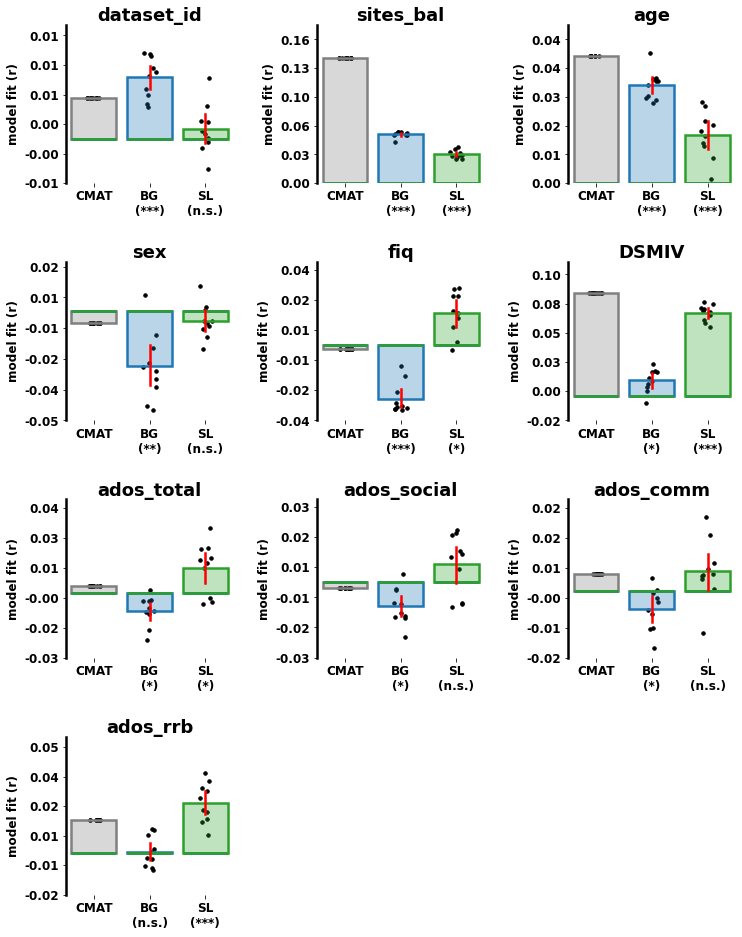

In [18]:
ncols = 3
nrows = int(np.ceil(len(keys)/3))
plt.figure(figsize=np.array((ncols,nrows))*4)

for i,key in enumerate(keys):
    ax = plt.subplot(nrows,ncols,i+1)
    plot_nice_bar(key,rsa_res,
                  ax=ax,figsize=None,
                  dpi=300,fontsize=12,
                  fontsize_star=12,
                  fontweight='bold',
                  line_width=2.5,
                  marker_size=12,title=keys[i],lbls=[inMat[j]['label'] for j in range(len(inMat))])
    
plt.subplots_adjust(
    left=None,
    bottom=None,
    right=None,
    top=None,
    wspace=.5,
    hspace=.5)

In [19]:
## SFARI data

In [20]:
sfari_cmats = np.load('../Data/cmats_SFARI_S134.npy')
sfari_cmats.shape

(134, 51, 51)

In [21]:
sfari_data = np.load(os.path.join(save_dir,'sfari_latents.npz'))
sfari_z10 = sfari_data['Z_sample100'][0:10,:,:]
sfari_s10 = sfari_data['S_sample100'][0:10,:,:]
sfari_data
list(sfari_data.keys())

['Z_mu',
 'Z_sigma',
 'Z',
 'S_mu',
 'S_sigma',
 'S',
 'Z_sample100',
 'S_sample100',
 'recon_td_mu',
 'recon_asd_mu']

In [22]:
sfari_df = pd.read_csv('../Data/sfari_df_S134.csv')
sfari_df['genotype_16p'] = dummy_ordinal(sfari_df['family_type'].values)
sfari_patients = sfari_df['genotype_16p'].isin([1,2]).values
sfari_df = sfari_df.iloc[sfari_patients]

sfari_df['DSMIV'] = dummy_ordinal(sfari_df['svip_diagnosis_m1'].values)
sfari_df['sex_ord'] = dummy_ordinal(sfari_df['sex'].values)
sfari_df['diag'] = sfari_df['latest_clinical_asd_dx'].values*1

sfari_df.head()

,Unnamed: 0,SFARI_ID,BIDS_ID,site,age_years,latest_clinical_asd_dx,svip_diagnosis_m1,family_type,genetic_status_16p,ados_module,...,svip_neuro_exam.background.head_circum_perc,svip_neuro_exam.background.head_circum_z_score,svip_neuro_exam.measure.eval_age_months,svip_neuro_exam.measure.measure_type,dur_run1,dur_run2,genotype_16p,DSMIV,sex_ord,diag
0,0,14702.x3,sub-001,60,8,False,non-spectrum-dx,16p-deletion,deletion,ados-2,...,NaN,2.18,119.0,svip-neuro-exam,5.00,4.25,1,4,2,0
1,2,14705.x14,sub-003,50,34,False,no-diagnosis,16p-duplication,duplication,ados-4,...,NaN,NaN,405.0,svip-neuro-exam,4.45,3.90,2,3,1,0
2,5,14714.x18,sub-006,60,21,False,no-diagnosis,16p-deletion,deletion,ados-4,...,NaN,0.49,249.0,svip-neuro-exam,6.00,6.00,1,3,2,0
3,8,14723.x17,sub-009,60,5,False,non-spectrum-dx,16p-duplication,duplication,ados-2,...,NaN,NaN,60.0,svip-neuro-exam,5.20,5.30,2,4,2,0
4,10,14725.x46,sub-011,50,10,False,no-diagnosis,16p-duplication,duplication,ados-3,...,NaN,-2.35,120.0,svip-neuro-exam,4.30,2.00,2,3,1,0


In [23]:
sfari_df.groupby('svip_diagnosis_m1').count()

,Unnamed: 0,SFARI_ID,BIDS_ID,site,age_years,latest_clinical_asd_dx,family_type,genetic_status_16p,ados_module,age_months,...,svip_neuro_exam.background.head_circum_perc,svip_neuro_exam.background.head_circum_z_score,svip_neuro_exam.measure.eval_age_months,svip_neuro_exam.measure.measure_type,dur_run1,dur_run2,genotype_16p,DSMIV,sex_ord,diag
svip_diagnosis_m1,,,,,,,,,,,,,,,,,,,,,
aspergers-disorder,1,1,1,1,1,1,1,1,1,1,...,0,1,1,1,1,1,1,1,1,1
autistic-disorder,4,4,4,4,4,4,4,4,4,4,...,0,3,3,3,4,4,4,4,4,4
no-diagnosis,12,12,12,12,12,12,12,12,12,12,...,0,8,12,12,12,12,12,12,12,12
non-spectrum-dx,25,25,25,25,25,25,25,25,25,25,...,0,20,25,25,25,25,25,25,25,25
pdd-nos-atypical-autism,3,3,3,3,3,3,3,3,3,3,...,0,2,3,3,3,3,3,3,3,3


In [24]:
v1 = {'label' : 'CMAT', 'data' : flatten_cmat(sfari_cmats[sfari_patients,:,:]), 'data_scale' : 'ratio', 'metric' : 'euclidean'}
v2 = {'label' : 'BG', 'data' : sfari_z10[:,sfari_patients,:], 'data_scale' : 'ratio', 'metric' : 'euclidean'}
v3 = {'label' : 'SL', 'data' : sfari_s10[:,sfari_patients,:], 'data_scale' : 'ratio', 'metric' : 'euclidean'}
inMat = [v1,v2,v3]

In [25]:
rsa_res = dict()
keys = ['site', 'age_years','sex_ord', 'genotype_16p','DSMIV','diag','best_full_scale_iq','best_nonverbal_iq', 'best_verbal_iq', 'ados_css','rrb_css', 'sa_css']
data_scale = ['ordinal', 'ratio','ordinal', 'ordinal','ordinal','ordinal','ratio','ratio', 'ratio', 'ratio','ratio', 'ratio']

for i in tqdm(range(len(keys))):
    rsa_res.update({keys[i] : key_rsa(inMat,keys[i],df=sfari_df,model_scale=data_scale[i])})

100%|██████████| 12/12 [00:02<00:00,  5.86it/s]


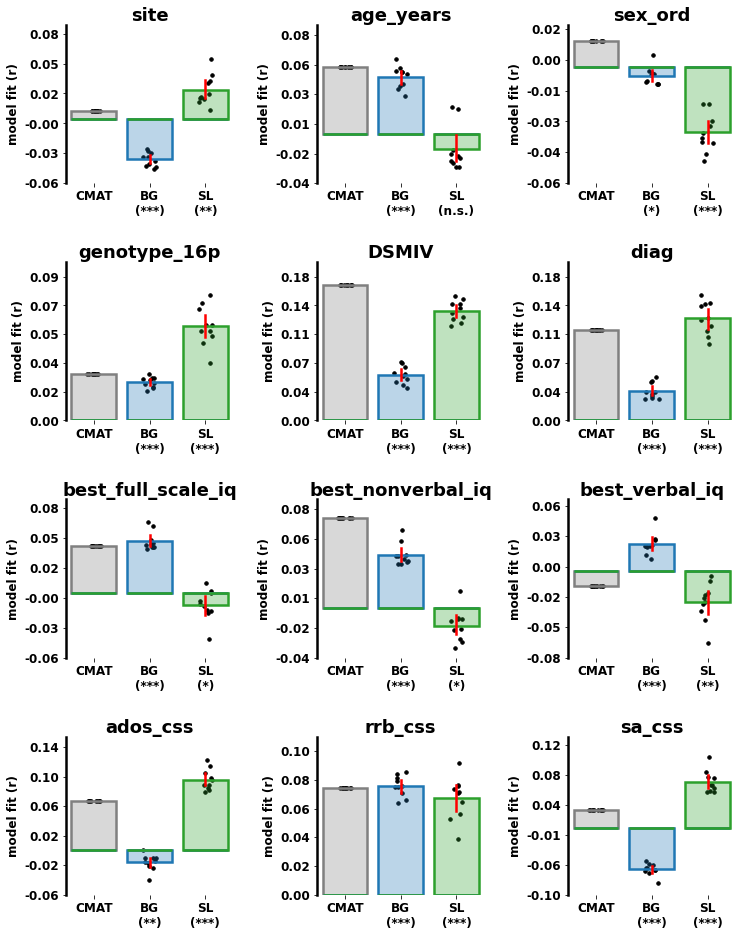

In [26]:
ncols = 3
nrows = int(np.ceil(len(keys)/3))
plt.figure(figsize=np.array((ncols,nrows))*4)

for i,key in enumerate(keys):
    ax = plt.subplot(nrows,ncols,i+1)
    plot_nice_bar(key,rsa_res,
                  ax=ax,figsize=None,
                  dpi=300,fontsize=12,
                  fontsize_star=12,
                  fontweight='bold',
                  line_width=2.5,
                  marker_size=12,title=keys[i],lbls=[inMat[j]['label'] for j in range(len(inMat))])
    
plt.subplots_adjust(
    left=None,
    bottom=None,
    right=None,
    top=None,
    wspace=.5,
    hspace=.5)

In [27]:
sfari_df.columns

Index(['Unnamed: 0', 'SFARI_ID', 'BIDS_ID', 'site', 'age_years',
       'latest_clinical_asd_dx', 'svip_diagnosis_m1', 'family_type',
       'genetic_status_16p', 'ados_module', 'age_months', 'best_full_scale_iq',
       'best_nonverbal_iq', 'best_verbal_iq', 'clinical_asd_dx', 'ados_css',
       'rrb_css', 'sa_css', 'sex', 'genetic_status_1q', 'collection',
       'date_of_evaluation', 'eval_age_months', 'family',
       'genetic_status_info_source', 'father', 'htwhc.bmi',
       'htwhc.bmi_z_score', 'htwhc.head_circum_1', 'htwhc.head_circum_2',
       'htwhc.head_circum_3', 'htwhc.head_circum_final',
       'htwhc.head_circum_z_score', 'htwhc.height', 'htwhc.height_z_score',
       'htwhc.measure.eval_age_months', 'htwhc.measure.measure_type',
       'htwhc.role', 'htwhc.weight', 'htwhc.weight_z_score',
       'included_in_longitudinal_dataset', 'individual.family',
       'inheritance_information', 'inherited_status_info_source',
       'initial_clinical_asd_dx', 'measure_type', 'mo